# Index

# 1. Libraries setup

### Import the fastai library

In [19]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Import functionality libraries

In [66]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from PIL import Image # Python Image Library, get sizes from images
from collections import Counter # Class for counting purposes
from math import exp
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

### Check CUDA is enabled

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA.

In [21]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN

In [22]:
torch.backends.cudnn.enabled

True

<br>
<br>
# 2. Environment setup

### Environment

The environment overview

```
./input
│   train.csv    
│
└─── train
│   │   dog.128945.jpg
│   │   cat.1238.jpg
│
│
└─── test
│   │   1234.jpg
│   │   2131232.jpg
│  
│   
└─── submission
    │   submission1.csv
    │   submission2.csv
```

### Initialize the environment variables

In [23]:
INPUT_PATH = ".\\input"
TRAIN_PATH = f'{INPUT_PATH}\\train'
DOWNLOAD_PATH = "C:\\Users\\David\\.kaggle\\competitions\\dogs-vs-cats-redux-kernels-edition"

### Download the data from kaggle

Instructions to use the kaggle API: https://github.com/Kaggle/kaggle-api <br>
Remember to accept the rules of the competition, otherwise it won't work.

In [24]:
if (os.system("kaggle competitions download -c dogs-vs-cats-redux-kernels-edition") == 0): print("Compressed files ready")

Compressed files ready


### Create the input directory

In [25]:
if not os.path.exists(f'{INPUT_PATH}'):
    os.mkdir(f'{INPUT_PATH}')

### Extract the data to the input directory

Check the download directory

In [26]:
os.listdir(DOWNLOAD_PATH)

['sample_submission.csv', 'test.zip', 'train.zip']

Extract the data

In [27]:
if "train" not in os.listdir(INPUT_PATH):
    print("Extracting the training set...")
    train_zip = zipfile.ZipFile(DOWNLOAD_PATH+"\\train.zip", mode="r")
    train_zip.extractall(INPUT_PATH)
    train_zip.close()
    
if "test" not in os.listdir(INPUT_PATH):
    print("Extracting the test set...")
    test_zip = zipfile.ZipFile(DOWNLOAD_PATH+"\\test.zip", mode="r")
    test_zip.extractall(INPUT_PATH)
    test_zip.close()

print("All files ready")

All files ready


### Create the submission directory

In [28]:
if not os.path.exists(INPUT_PATH+"\\submission"): 
    os.mkdir(INPUT_PATH + "\\submission")
print("Submmission directory ready")

Submmission directory ready


### Check everything is correct

In [29]:
expected_dir = ['submission','train',  'test']
current_dir = os.listdir(INPUT_PATH)
print(current_dir)
if set(expected_dir).issubset(set(current_dir)): print("Everything is correct")

['models', 'submission', 'test', 'tmp', 'train', 'train.csv']
Everything is correct


<br>
<br>
# 3. Data exploration

<br>
## 3.1 Training dataframe

### Training dataframe creation

Generate the pandas dataframe that will link each image to the corresponding category.<br>
The category is determined by the prefix of the image.

In [30]:
images_filenames = os.listdir(TRAIN_PATH)
images_classes = [image_filename[0:3] for image_filename in images_filenames]

In [31]:
train_df = pd.DataFrame({"Filename" : images_filenames, "Category" : images_classes})
train_df = train_df[["Filename", "Category"]]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
Filename    25000 non-null object
Category    25000 non-null object
dtypes: object(2)
memory usage: 390.7+ KB


### Training dataframe structure


As we can see we have two columns, corresponding to the image filename path and the class, either a dog or a cat.

In [32]:
train_df.head()

,Filename,Category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [33]:
train_df.to_csv(path_or_buf=f'{INPUT_PATH}\\train.csv', index=False)

<br>
## 3.2 Labeled dataset analysis

### Number of training examples and categories

In [34]:
n_train_images = train_df["Filename"].count()
categories = train_df["Category"].unique()
n_categories = len(train_df["Category"].unique())
ratio_images_per_category = round(n_train_images / n_categories, 2)
print(f"Number of training images: {n_train_images}")
print(f"Number of categories: {n_categories}")
print(f"Average images per category: {ratio_images_per_category}")

Number of training images: 25000
Number of categories: 2
Average images per category: 12500.0


Quite a lot of images and perfectly balanced

<br>
### Sizes of the images

Let's plot the most common sizes of the training set

In [35]:
# Create a counter object with the sizes of the training set images
img_sizes_freqs = Counter([Image.open(f'{TRAIN_PATH}//{i}').size for i in train_df['Filename']])
# Extract the 10 most common sizes
most_common_sizes = img_sizes_freqs.most_common(20)

Plot a histogram to visualize it better.

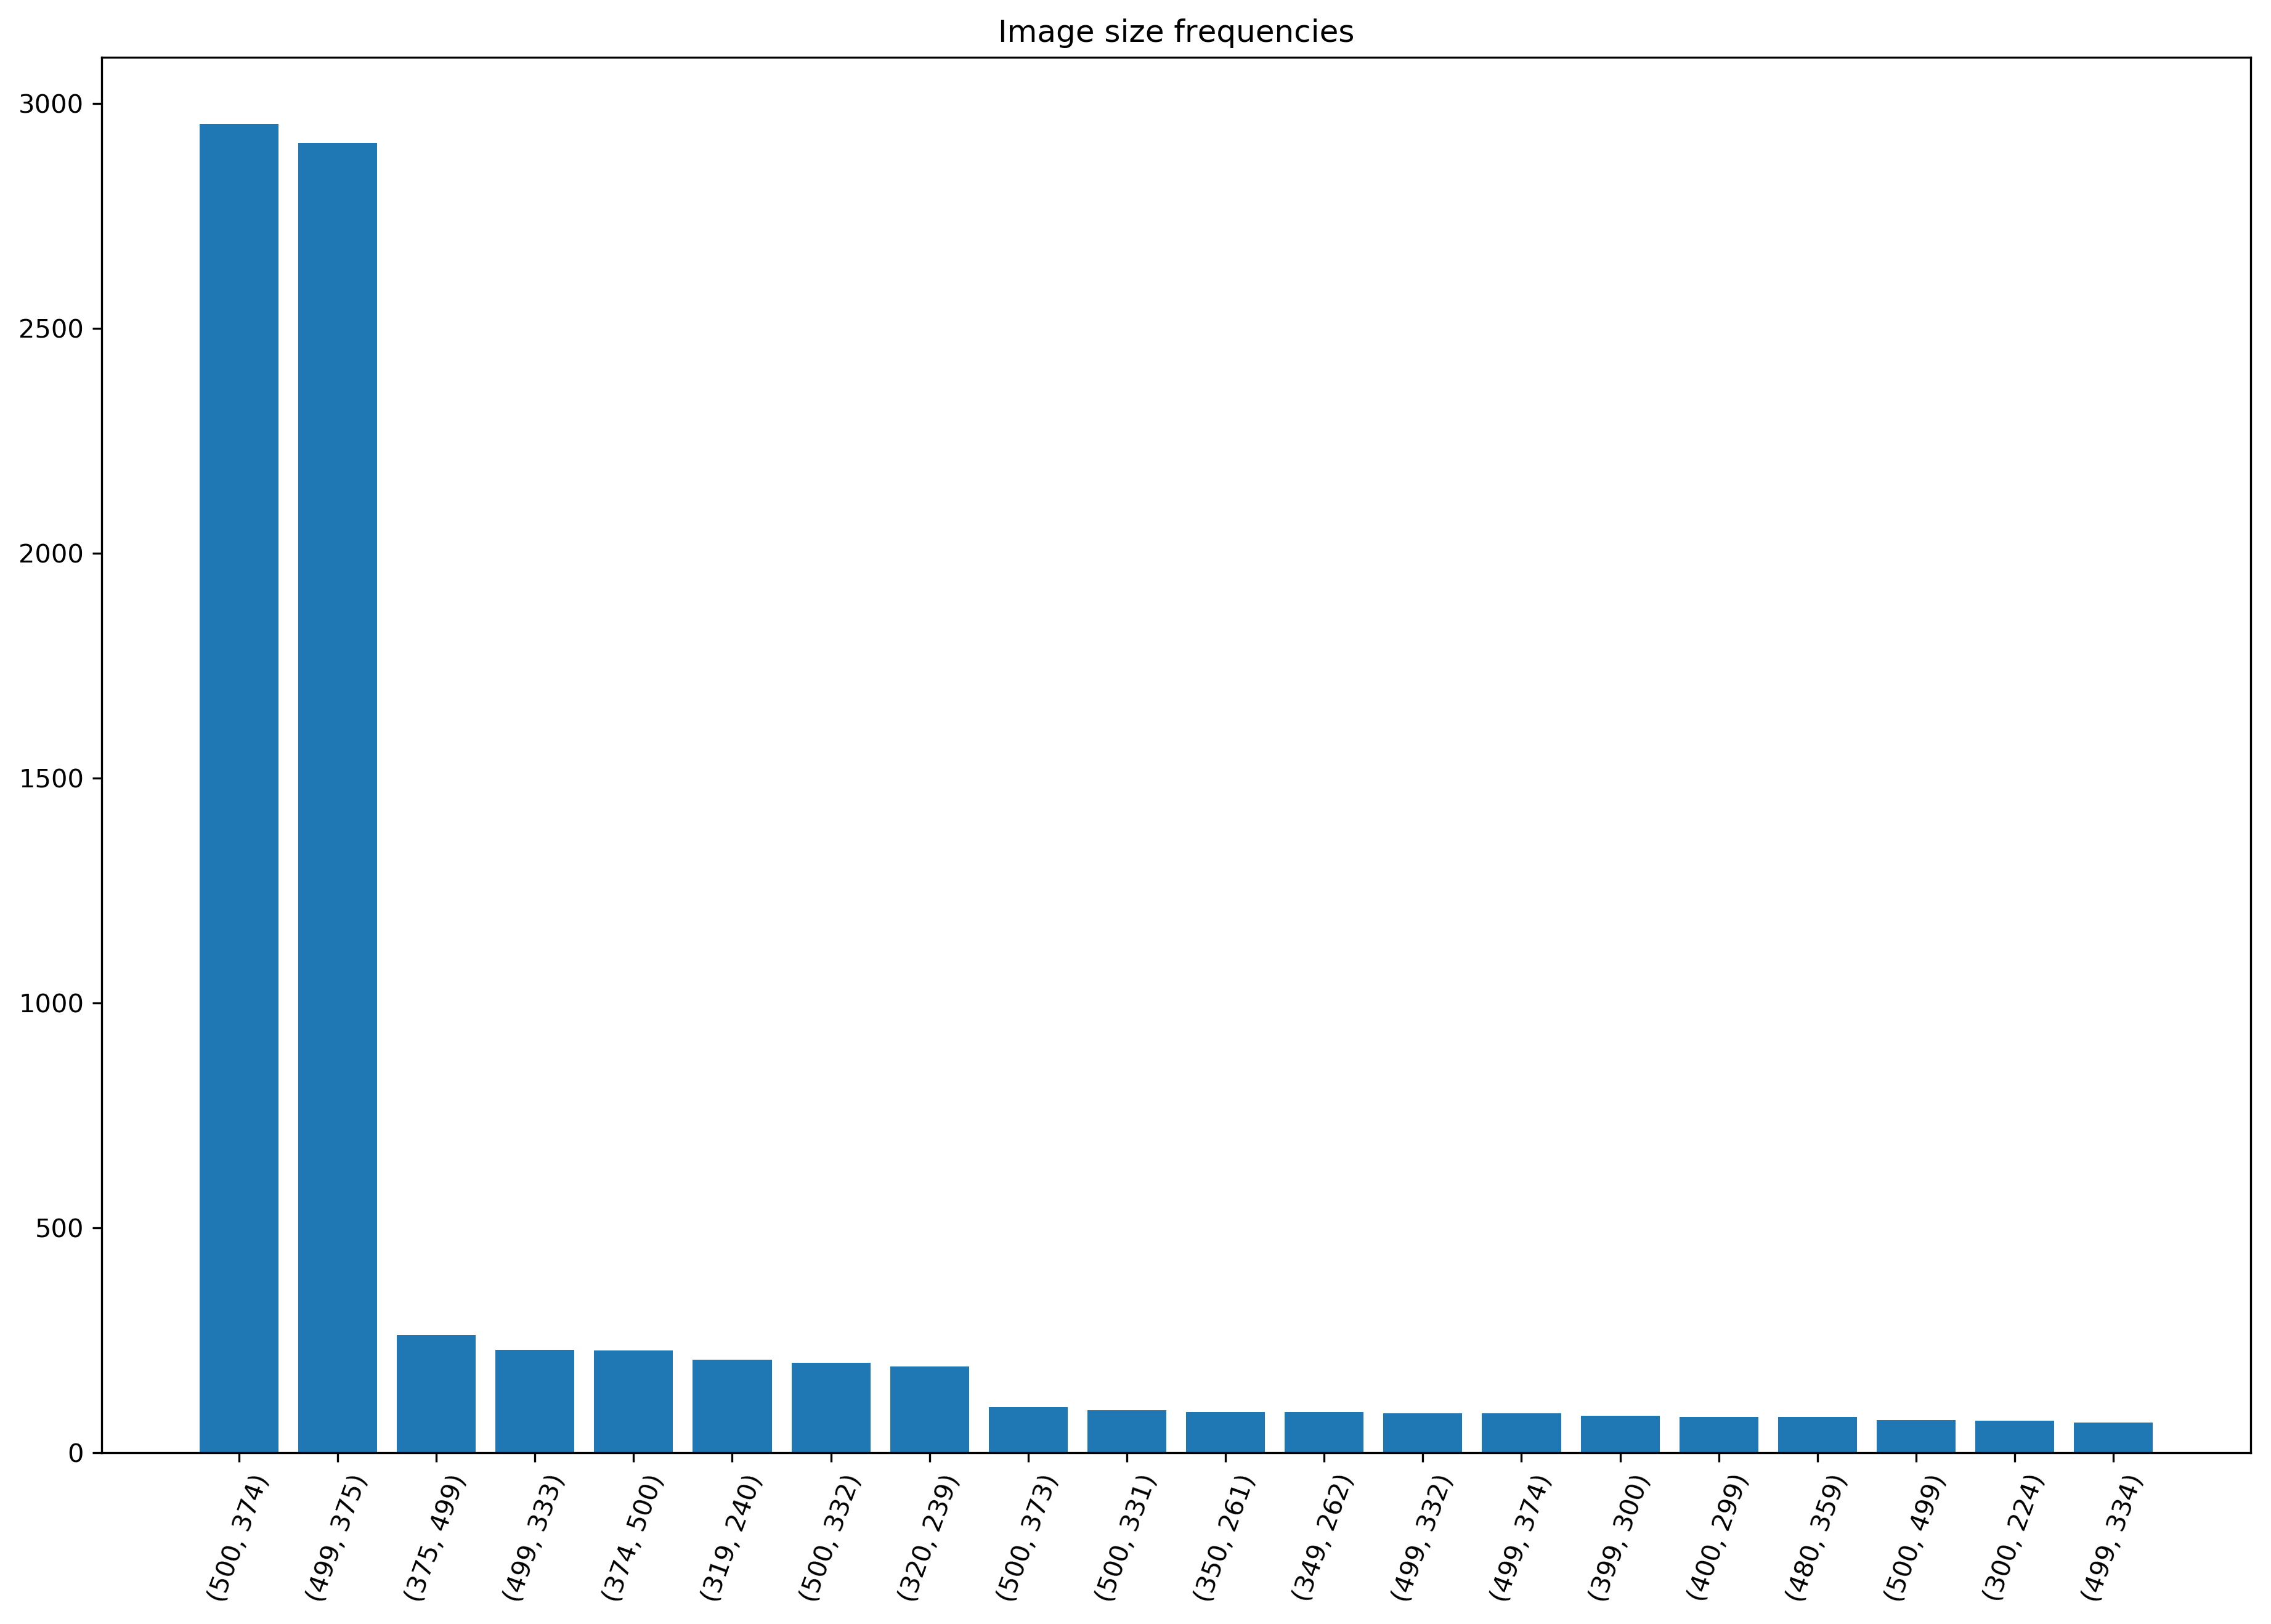

In [36]:
sizes = [img_size_freq[0] for img_size_freq in most_common_sizes]
freqs = [img_size_freq[1] for img_size_freq in most_common_sizes]
plt.figure(figsize=(15,10), dpi=300)
plt.bar(range(len(freqs)), freqs, align="center")
plt.xticks(range(len(sizes)), sizes, rotation = 70)
plt.title("Image size frequencies")
plt.show()

Sizes don't vary that much and are grouped in mostly 2 categories.

<br>
## 3.3 Training data visualization

### Welcoming pet

Load a random image to welcome us.

In [37]:
def get_random_image_path():
    random_image = train_df.sample(1)["Filename"].values[0]
    random_image_path = f'{TRAIN_PATH}\\{random_image}'
    return random_image_path

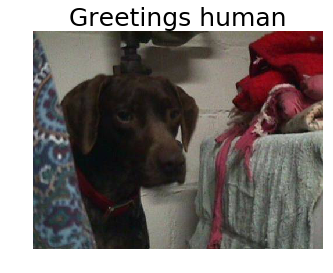

In [38]:
welcoming_pet =  plt.imread(get_random_image_path())
image_plot = plt.imshow(welcoming_pet)
plt.axis("Off")
title = plt.title("Greetings human", fontsize=25)

<br>
### Training set images visualization

Create a function to retrieve n random images from the dataset.

In [39]:
def get_random_labeled_images(n):
    """Returns iterable of n lists of random whale images and whale id pairs from the training dataset
        [img_name1, img1], [img_name2, img2], ..., [img_name3, img3]
    """
    train_sample = train_df.sample(n)
    categories = [category for category in train_sample["Category"]]
    images = [plt.imread(f'{TRAIN_PATH}\\{image_filename}')  for image_filename in train_sample["Filename"]]
    labeled_images = zip(categories, images)
    return labeled_images

<br>
Create a function to display n whales with the corresponding identifier.

In [40]:
def plot_random_labeled_images(n):
    """Plots n random images with the corresponding identifier
    """
    labeled_images = get_random_labeled_images(n)
    columns = 5
    rows = (n // columns) + 1
    width, height = columns * 3, rows * 3
    figure = plt.figure(figsize=(width,height))
    for i, labeled_image in enumerate(labeled_images):
        subplot = figure.add_subplot(rows,columns,i+1)
        subplot.axis("Off")
        plt.title(labeled_image[0])
        plt.imshow(labeled_image[1])

<br>
<a id="display_whales"> </a>
Let's see some puppies


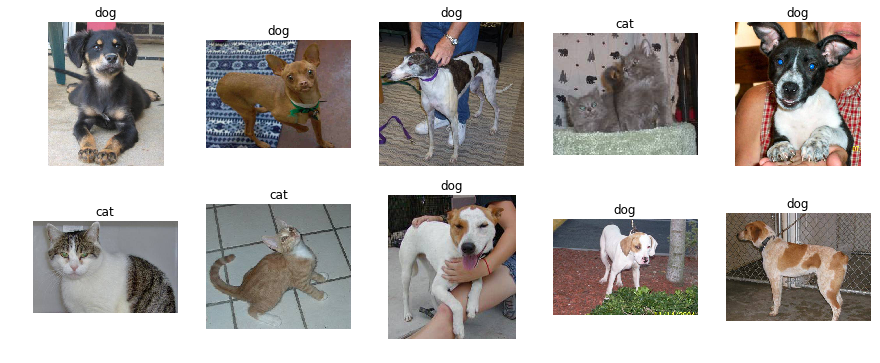

In [41]:
plot_random_labeled_images(10)

<br>
<br>
# 4. Model training

Building a successful neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also, we shouldn't make decisions based on "gut feelings" or "divine visions".

### Architecture
The chosen architecture is resnet34, it comes pretrained with a huge imagenet dataset and it's not too complex.

In [42]:
arch = resnet34

### Transformations size
Resnet34 was trained on mostly 224·224 to 300·300 images sizes. For that reason, transforming the training images to that size should result in decent result.

In [43]:
size = 224

### Batch size
Batch size defines how many images we take to compute the approximated gradient for stochastic gradient descent.<br>
If it's too big it will take a long time to converge and if it's to small the predictions won't be precise enough and it may not converge.<br>
For what I've seen, 64 seems like a reasonable choice.

In [44]:
batch_size = 64

### Transformations augmentations
For this model we will perform the following transformations:
<ul>
<li> Side on
<li> Zoom
<ul>

First, we define the transformations

In [45]:
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_side_on, max_zoom=1.1)

The following function uses an interator to return ranfom augmentations.

In [46]:
def get_augs():
    data = ImageClassifierData.from_csv(path=INPUT_PATH, csv_fname=f'{INPUT_PATH}\\train.csv',
                                    folder="train", tfms=tfms, test_name="test", bs=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

We extract some augmented images with the previous function

In [47]:
augmented_images = np.stack([get_augs() for i in range(6)])

Plot the results

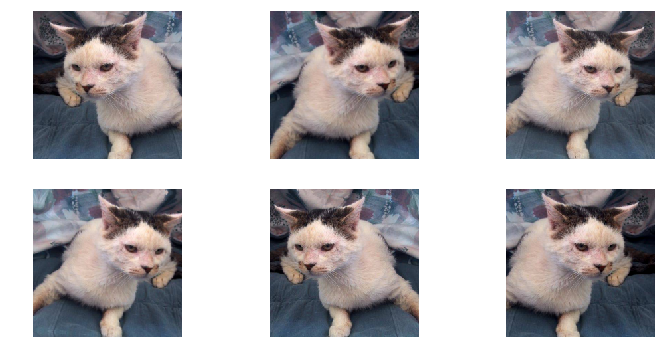

In [48]:
plots(augmented_images, rows=2)

### Validation set size

To fine thune the model we will use the 20% of the dataset. Then, with the definitive model architecture, we will use the whole dataset to train it.
<ol>
<li> We will use a standard 20% of the dataset as a validation set.
<li> We will train the network with that learning rate on the whole dataset. 
</ol>

In [49]:
step = 1
if step == 1:
    val_idxs = get_cv_idxs(n_train_images, val_pct=0.2)
# The fastai library requires at least one image for the validation set. A low percentage
elif step == 2:
    val_idxs = get_cv_idxs(n_train_images, val_pct=0.001)

### Data transformation
Now we can adapt the training set images to train a neural net based on the previous options.<br>
We don't have folders for each category so we will create the data from the csv file.

In [50]:
data = ImageClassifierData.from_csv(path=INPUT_PATH, csv_fname=f'{INPUT_PATH}\\train.csv',
                                    folder="train", tfms=tfms, test_name="test",
                                    val_idxs = val_idxs, bs=batch_size)

### Precompute
In this exercise we are using a pre trained model and we are adding some layers for our particular purpose.<br>
By default, the pre-trained layers will remain frozen (won't be trained) unless we specify otherwise.<br>
For that reason, we can think of our model as a frozen pre-trained neural net and our particular layers which we have to train.<br>
Precompute simply means to run the images through the frozen part of our neural net and use the outputs to train the non frozen part. It simply speeds up the training process in this particular case.

### Model creation
Create our model. 

In [51]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

### Learning rate
Compute the learning rate related info

In [52]:
learn.lr_find()

 85%|████████▍ | 266/313 [00:03<00:00, 75.92it/s, loss=0.461]


Our learning instance has a scheduler that exponentially increases the learning rate with each batch.<br>
Let's plot how this scheduler increases the learning rate with each iteration.

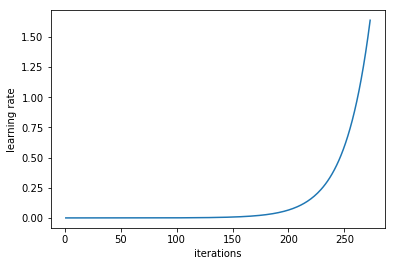

In [53]:
learn.sched.plot_lr()

Check how the loss decreases faster for a bigger learning rate until it becomes unstable.

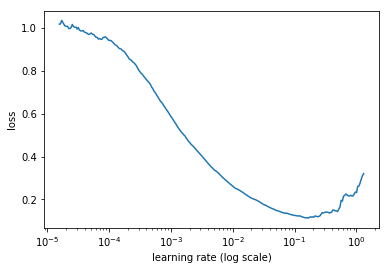

In [54]:
learn.sched.plot()

A learning rate of 0.1 seems like a reasonable choice.

### Stochastic gradient descent with restarts
We can relate the "size" of the local minimum to the generalitzation it can achieve.<br>
I like to think that noise has this cahotic highly variant nature whereas the perception we are looking for has a much more stable and invariant nature.<br>
It makes sense then that a huge stable local minimum predicts more on the perception than the noise.<br>
Using this theory we will restart the learning sheduler to unconverge from "small" local minimums in the hope to find a better "big" more generalitzating minimum.

### Cycle length
This parameter defines how many cycles or epochs we run before resetting the learning rate scheduler.

### Training
Train the model with the chosen learning rate for 2 epochs or cycles.<br>
The loss function used is the cross-entropy function.

In [55]:

learn.fit(lrs=0.01, n_cycle=2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.056403   0.034519   0.9892    
    1      0.046443   0.03099    0.9896                        



[array([0.03099]), 0.9896]

### Fine tunning

To fine tune our model we will unfreeze some previous layers.

In [56]:
learn.unfreeze()

Neural nets use a chain of abstractions to build a perception. The early layers work on general abstract patter recognition like edges or textures.<br>
To solve a particular problem, we will train the last layers to adapt to that particular problem. However, early layers don't have to be tuned that much thanks to their general nature.<br>
For that reason, we define an array of learning rates from the earlier layers to the latest.

In [57]:
lr=np.array([1e-4,1e-3,1e-2])

As we are approaching a more general minimum with SGDR (Stochastic Gradient Descent with Restarts) we would like to take longer to restart so our algorithm can converge.<br>
Cycle_mult does that, everytime a cycle ends the next cycle will be of length cycle_mult * previous_cycle.<br>
In this case: [1,2,4] for a total of 7 cycles.

In [58]:
learn.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.056048   0.02879    0.9904    
    1      0.044359   0.027393   0.9908                       
    2      0.040987   0.026885   0.9908                       
    3      0.045625   0.02617    0.9908                       
    4      0.035692   0.024953   0.9906                       
    5      0.04166    0.025384   0.99                         
    6      0.037974   0.02519    0.99                         



[array([0.02519]), 0.99]

Finally, so we don't have to compute the model again, we can save the weights and the configuration in a file.<br>

In [120]:
model_name = "224_all"
learn.save(model_name)

The model is now saved in the "models" directory as 224_all.h5

### Load trained model
We can use an already trained model in the models directory.

In [ ]:
learn.load('224_all')

<br>
<br>
# 5. Model validation

### Understanding the output

We should be worried about the chosen activation function for our last layer, as it's nature is going to greatly define the neural network.<br>
Let's check out what the last layer activation function is.

In [227]:
learn[-1]

LogSoftmax()

The last layer outputs the logarithm of the softmax function of the activations of the previous layer (read that again).

In this case, the softmax function presents the following properties:
   - The sum of all the values of the output is equal to 1
   - It tends to "choose" only one category over the others exponentially

Now let's think about our current dataset. This neural network has to predict if the animal is either a dog or a cat.
So we could see our prediction as a mutual exclusion problem where it only makes sense to predict one kind of animal.
This goes well with the properties of the softmax function, so it seems like a reasonable choice to use as the last layer.


#### Logarithm of the softmax function

$$L_i = \log\left(\frac{e^{i}}{ \sum_j e^{j} }\right)$$
The output of the softmax function ranges from 0 to 1:<br>
 - 0 corresponds to a very unlikely match<br>
 - 1 corresponds to an almost certain match

The output of the logarithm of the softmax function ranges from -inf to 0:<br>
 - -inf corresponds to a very unlikely match<br>
 - 0 corresponds to an almost certain match


### Making the validation set predictions

Important reminder. All the prediction related data of our neural network is contained in the data object we created in the model training.<br>
<ul>
    <li>To obtain the ordered classes we use the <b>data.classes</b> attribute.
    <li>To obtain the ordered validation images we use the <b>data.val_ds.fnames</b> attribute.
    <li>To obtain the original labels of the validation set we use <b>data.val_y</b> attribute.
</ul>

We set the is_test flag to False to tell the model to predict on the validation set.<br>
We compute the exponential of the output to get the probabilities in the 0 to 1 range.

### Test time augmentation
There's another neat trick we can apply to obtain better results.
TTA uses the average prediction for n augmentations of the original test image. If the augmentations are correctly tuned, TTA offers a more robust prediction.<br>
TTA getting the most certain prediction?

In [150]:
TTA_enabled_validation = True

In [95]:
if TTA_enabled_validation:
    val_log_predictions, dummy = learn.TTA(n_aug=4, is_test=False)
    val_probabilities = np.mean(np.exp(val_log_predictions),0)
else:
    val_log_predictions = learn.predict(is_test=False)
    val_probabilities = np.exp(val_log_predictions)
val_predictions = np.argmax(val_probabilities, axis=1) # The index of the max value directly maps the category (0 -> cat, 1 -> dog)

Using TTA we can get a 20% error reduction at this point, that's a huge improvement for such little effort.

In [96]:
accuracy_np(val_probabilities, data.val_y)

0.992

### Confusion matrix

A confusion matrix is a vary useful way to visualize errors and correlations in the validation set, specially with a few categories.


To build the confusion matrix we must provide the real values and the predicted values.

In [97]:
cm = confusion_matrix(data.val_y, val_predictions)

Finally, we supply the classes names.

[[2498   17]
 [  23 2462]]


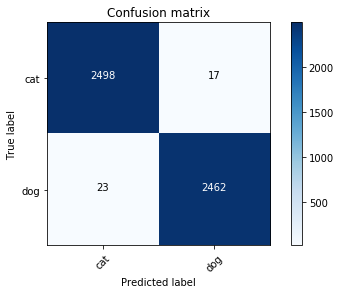

In [98]:
plot_confusion_matrix(cm, data.classes)

### Predictions format

The prediction is represented as an array of predictions for each of the categories  sorted in the appearing order in data.test_ds.fnames.<br>
In this case, the model is a single label classifier for 2 categories, so the prediction for an image is the index of the category.<br>


In [100]:
print(f"Example of a prediction for an image: {val_predictions[42]}")
print(f"The size of the probabilities array is: {np.size(val_probabilities[42])}")

Example of a prediction for an image: 0
The size of the probabilities array is: 2


### Analyzing the validation set predictions

First we will create some functions to plot the results

Random indexes from mask gets n random indexes of the validation predictions if that index is True in the mask array.<br>
np.where(mask)[0] returns the indexes where the mask element is True: [True, False, True] --> [0,2]<br>
It doesn't replace the chosen images to avoid duplicates.

In [101]:
def random_indexes_from_mask(mask_array, n): 
    return np.random.choice(np.where(mask_array)[0], n, replace=False)

Random indexes by prediction returns n random indexes of the predictions that are either correct or incorrect depending on is_correct.<br>
It supplies the mask array to random indexes from mask which then selects the images indexes.

In [102]:
def random_indexes_by_prediction(is_correct, n):
    mask_array = (val_predictions == data.val_y) == is_correct
    return random_indexes_from_mask(mask_array, n)

Plot image with title selects the images and the probabilites of the provided category and plots them.<br>

In [103]:
def plot_image_with_title(idxs, title, category):
    images = [plt.imread(f"{INPUT_PATH}\\{data.val_ds.fnames[i]}") for i in idxs] # Select the images filenames and create a list of the loaded images
    images_probabilities = [val_probabilities[i][category] for i in idxs] # Select the y category probability for each image
    print(title)
    return plots(images, rows=1, titles=images_probabilities)

Plots configures the plotting options.

In [104]:
def plots(imgs, figsize=(12,6), rows=1, titles=None):
    figure = plt.figure(figsize=figsize)
    columns = len(imgs)//rows
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, columns, i+1)
        subplot.axis("Off")
        if titles is not None: subplot.set_title(titles[i], fontsize=16)
        plt.imshow(imgs[i])

### Random correctly classified images

Let's see some correctly classified images

Correctly classified


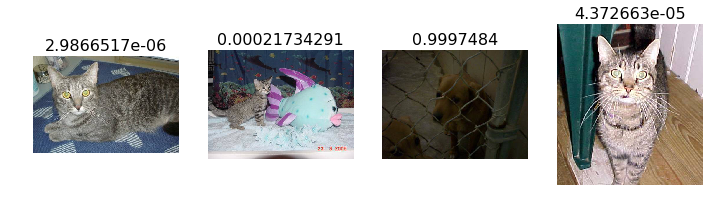

In [105]:
plot_image_with_title(random_indexes_by_prediction(True, n=4), "Correctly classified", category=1)

Let's see some incorrectly classified images

### Random incorrectly classified images

Incorrectly classified


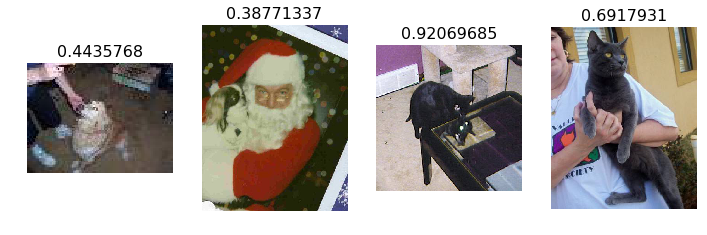

In [111]:
plot_image_with_title(random_indexes_by_prediction(False, n=4), "Incorrectly classified", category=1)

### Most correct, incorrect and uncertain

Most by mask gets a mask of the correctly or incorrectly classified class and sorts the indexes to extract the most correct, incorrect or uncertain images.<br>
np.argsort() sorts in increasing order.<br>
Because we are using the dogs probabilities to compute

In [113]:
def most_by_mask(mask, y, mult):
    indexes = np.where(mask)[0]
    sorted_indexes = indexes[np.argsort(mult * val_probabilities[:,y][indexes])[-4:]]
    return sorted_indexes

Because np.argsort() sorts in increasing order, and we get the last n sorted indexes, when finding the most inccorrect images for a category we must multiply the probabilities by -1 so the worst guesses have the highest numbers. For that reason we generate the mult variable.<br>
Ex: [0.4, 0.2, 0.01, 0.3] --> (-1) --> [-0.4, -0.2, -0.3, -0.01] <br><br>
The mask array generation can be thought as follows:
 - The current example is a valid (True) if the prediction is correct and we are looking for correct predictions and the category is the one selected.
 - The current example is a valid (True) if the prediction is incorrect and we are looking for incorrect predictions and the category is the one selected.

In [114]:
def most_by_correct(y, is_correct):
    mult = 1 if is_correct else -1
    mask_array = (val_predictions == data.val_y) == is_correct & (data.val_y == y)
    sorted_indexes = most_by_mask(mask_array, y, mult)
    return sorted_indexes

Most correct cats


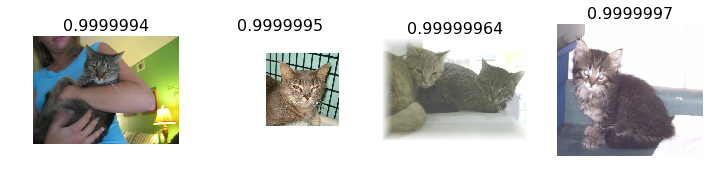

In [115]:
plot_image_with_title(most_by_correct(0, True), "Most correct cats", 0)

Most correct dogs


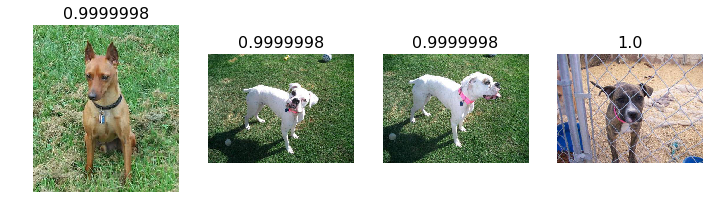

In [116]:
plot_image_with_title(most_by_correct(1, True), "Most correct dogs", 1)

Most incorrect cats


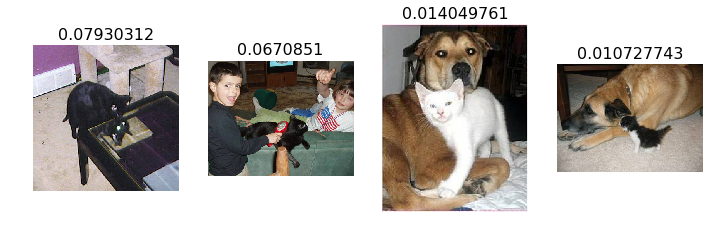

In [117]:
plot_image_with_title(most_by_correct(0, False), "Most incorrect cats", 0)

Most incorrect dogs


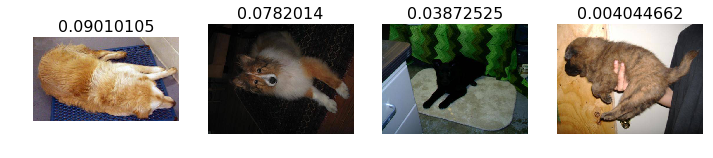

In [118]:
plot_image_with_title(most_by_correct(1, False), "Most incorrect dogs", 1)

To check the most uncertain:
 - Select thr probabilities of one category (in this case dogs)
 - Substract 0.5
 - Compute the absolute value
 - Get the n smallest elements (closer to 0.5).

Most uncertain predictions


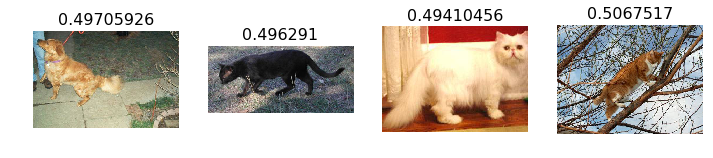

In [119]:
most_uncertain_indexes = np.argsort(np.abs(val_probabilities[:,1] -0.5))[:4]
plot_image_with_title(most_uncertain_indexes, "Most uncertain predictions", 1)

<br>
<br>
# 5. Model predictions

### 5.1 Making the test set predictions

Set the is_test flag to True to tell the model to predict on the test set.<br>
Compute the exponential of the output to get the probabilities in the 0 to 1 range.
We can enable TTA on the test predictions.

In [138]:
TTA_enabled_test = True

In [139]:
if TTA_enabled_test:
    test_log_predictions, dummy = learn.TTA(n_aug=4, is_test=True)
    test_probabilities = np.mean(np.exp(test_log_predictions),0)
else:
    test_log_predictions = learn.predict(is_test=True)
    test_probabilities = np.exp(test_log_predictions)
test_predictions = np.argmax(test_probabilities, axis=1) # The index of the max value directly maps the category (0 -> cat, 1 -> dog)

The probabilities for m test cases will result in a list of the probabilities of each image for each category.<br>
It can be thought as an m*c matrix

In [141]:
np.shape(test_probabilities)

(12500, 2)

Check the output dimension is correct.

In [142]:
if np.shape(test_probabilities)[1] != n_categories:
    print("FATAL ERROR, output dimension doesn't match the number of categories")
else:
    print("Output dimension correct")

Output dimension correct


### 5.2 Extracting the dog probabilities


Dog is indexed as 1 in the categories array.

In [143]:
test_dog_probabilities = test_probabilities[:,1]

### 5.3 Linking the labels

Apply to all the predictions.

In [144]:
predicted_labels = [data.classes[index] for index in test_predictions]
print(f"An example of a prediction: {predicted_labels[42]}")

An example of a prediction: dog


### 5.4 Creating the test predictions dataframe

The dataset will have the following structure:
 - A column with the names of the images with a "filename" header
 - A column with the predicted category with the "category" header
 - A column with the probability of being a dog with the "dog probability" header

In [145]:
images_names_column = [image_file_name[5:-4] for image_file_name in data.test_ds.fnames]

Construct the pandas dataframe.<br>

In [146]:
predictions_df  = pd.DataFrame(data = {"filename":images_names_column, "category": predicted_labels,
                                       "dog_probability": test_dog_probabilities}, 
                                       columns=["filename", "category", "dog_probability"])
predictions_df.head()

,filename,category,dog_probability
0,1,dog,0.999954
1,10,cat,0.000003
2,100,cat,0.001332
3,1000,dog,0.999803
4,10000,dog,0.998709


### 5.5 Submission

In this kaggle competition, we upload the predictions as a csv file. A cross-entropy algorithm is used to evaluate the predictions. For that reason, we will directly provide the probabilities. The format is established as follows:<br>
<li> Extract the image filenames in a "id" column
<li> Extract the dog probabilities in a "label" column


From the test predictions dataframe

In [147]:
predictions_df_submission = predictions_df[["filename", "dog_probability"]].copy()
predictions_df_submission.columns= ["id", "label"]
predictions_df_submission.head()

,id,label
0,1,0.999954
1,10,0.000003
2,100,0.001332
3,1000,0.999803
4,10000,0.998709


Define the submission name and path.

In [148]:
submission_filename = "submission6"
submission_path = f"{INPUT_PATH}\\submission\\{submission_filename}.csv"

Create the submission file without the index column.

In [149]:
predictions_df_submission.to_csv(submission_path,index=False)

Generate a link to a direct download of the submission file.

In [137]:
FileLink(submission_path)

C:\Users\David\Desktop\Kaggle\cats_vs_dogs\input\submission\submission5.csv

### Conclusion

First submission got a 0.09264 score.<br>
Considering I didn't do any data augmentation or model specific training, it's not a bad result.<br> As I said, the first iteration only purpose was to create a solid pipeline.